The purpose of this notebook is to use the analytical model given in these 3 papers:

I:   http://adsabs.harvard.edu/abs/2016MNRAS.458.2848J

II:  http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1403.6835

III: http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1610.02399


In [203]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from colossus.halo.mass_so import R_to_M, M_to_R
from colossus.cosmology.cosmology import setCosmology,addCosmology
from colossus.halo.profile_nfw import NFWProfile
from scipy.optimize import brentq, bisect

In [204]:
params = {'flat': True, 'H0': 67.2, 'Om0': 0.3, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
addCosmology('myCosmo', params)
cosmo = setCosmology('myCosmo')

In [205]:
G = 4.30172e-06
# The gravitational constant G in kpc km2/M⊙/s2 .

In [206]:
print(M_to_R(1E12, 0.0, 'vir'))

def M_to_V(M, z, defin='vir'):
    return np.sqrt(G*M/M_to_R(M, z, defin)) # in km/s


204.13256528


# SHMF

Subhalo mass function is given by a fitting formula from paper I.

# Tidal radius

Paper I, Appendix B

In [207]:
def p1B2_c(M,z):
    return 4.67/(1.0+z)*(M/1e14)**-0.11

def f(x):
    return np.log(1 + x) - x/(1 + x)

def p1B1_M(M, R, z):
    Rvir = M_to_R(M,z,'vir')
    return M*f(p1B2_c(M,z)*R/Rvir)/f(p1B2_c(M,z))
# def p1B6_rt(Rp):
    

In [208]:
# NFW profile enclosed mass test: Colossus package vs formula from P1
M=1e10
z=0.5
c = p1B2_c(M,z)
print(c)
profile = NFWProfile(M=M, mdef = 'vir', z = z, c = c)
Rvir = profile.RDelta(0.0, 'vir')
print('Colossus: ', profile.enclosedMass(Rvir))

print('Paper I:  ', p1B1_M(M, Rvir, z=z))

8.574832029726158
Colossus:  12100158009.2
Paper I:   12100158009.2


4.010750270937957
-152649.281222 148645.549637
0.650838200607
0.650838200607


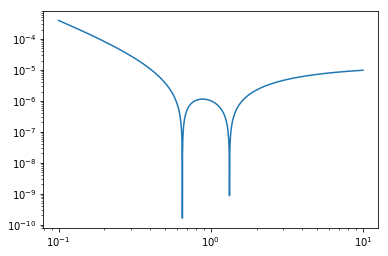

In [209]:

def M_to_Vc(M, R, z, defin='vir'):
    return np.sqrt(G*p1B1_M(M, R, z=z)/R) # in km/s

def p1B4_Phi(M,R,z):
    c = p1B2_c(M,z)
    Rvir = M_to_R(M,z,'vir')
    Vvir = M_to_V(M,z,'vir')
    return -Vvir**2*np.log(1.0+c*R/Rvir)/(f(c)*R/Rvir)

def p1B8_E(M, Rc, z):
    Vc = M_to_Vc(M, Rc, z)
    E = 0.5*Vc**2+p1B4_Phi(M, Rc, z)
    return E

def p1B9_L(M, Rc, z, eta):
    Vc = M_to_Vc(M, Rc, z)
    Lc = Rc*Vc
    L = eta*Lc
    return L

def p1B3(R, E, L):
    return 1.0/R**2 + 2.0 * (p1B4_Phi(M,R,z) - E)/L**2

def fun_Rp(M, Rc, z, eta):
    E = p1B8_E(M, Rc, z)
    L = p1B9_L(M, Rc, z, eta)
    return brentq(p1B3, Rc/100, Rc+1e-5, args=(E, L))


M=1e13
z=0.5
c = p1B2_c(M,z)
print(c)
profile = NFWProfile(M=M, mdef = 'vir', z = z, c = c)
Rvir = profile.RDelta(0.0, 'vir')

Rc = 1.*Rvir
eta = 0.9

E = p1B8_E(M, Rc, z)
L = p1B9_L(M, Rc, z, eta)
print(E,L)

R_list = np.logspace(np.log10(Rvir/10.),np.log10(Rvir*10),10000)
plt.plot(R_list/Rvir, np.abs(p1B3(R_list, E, L)))

def fun(x):
    return p1B3(x, E, L)

print(brentq(fun, Rvir/100, Rc)/Rvir)
print(rp(M, Rc, z, eta))
# plt.plot(R_list/Rvir, np.abs(2*2*(p1B4_Phi(M, R_list, z)-E)/L**2))
# plt.plot(R_list/Rvir, 1./ R_list**2)
# plt.plot(R_list/Rvir, 1./ R_list**2+2*2*(p1B4_Phi(M, R_list, z)-E)/L**2)
plt.xscale('log')
plt.yscale('log')
plt.show()

4.010750270937957
mm:  0.0094153020921
101.762977561 481.923812801
0.47415933933


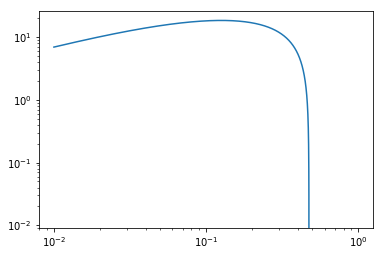

In [213]:
def p1B6_rt(rt, M, m, Rc, z, eta):
    Rp = fun_Rp(M, Rc, z, eta)
    mrt = p1B1_M(m, rt, z)
    MRp = p1B1_M(M, Rp, z)
    Omegap = L/(Rp**2)
    temp = (np.log(p1B1_M(M, Rp*1.001, z))-np.log(p1B1_M(M, Rp*0.999, z))) / \
        (np.log(Rp*1.001)-np.log(Rp*0.999))
    return Rp * ((mrt/MRp)/(2.0+Omegap**2*Rp**3/G/MRp-temp))**(1./3.) - rt
#     return mrt/MRp, Omegap**2*Rp**3/G/MRp, temp

def solve_rt(M, m, Rc, z, eta):
    c = p1B2_c(m,z)
    profile = NFWProfile(M=m, mdef = 'vir', z = z, c = c)
    rvir = profile.RDelta(0.0, 'vir')
    return bisect(p1B6_rt, 1e-5*rvir, 10*rvir, args=(M, m, Rc, z, eta))

M=1e13
z=0.5
m=M/100.
c = p1B2_c(M,z)
print(c)
profile = NFWProfile(M=M, mdef = 'vir', z = z, c = c)
Rvir = profile.RDelta(0.0, 'vir')

c = p1B2_c(m,z)
profile = NFWProfile(M=m, mdef = 'vir', z = z, c = c)
rvir = profile.RDelta(0.0, 'vir')

mrt = p1B1_M(m, rvir, z)
MRp = p1B1_M(M, Rvir, z)
print('mm: ', mrt/MRp)

Rc = .8*Rvir

eta=0.99

print(rvir, Rvir)
print(solve_rt(M, m, Rc, z, eta)/rvir)

R_list = np.logspace(np.log10(rvir/100.),np.log10(rvir*1),10000)
x = p1B6_rt(R_list, M, m, Rc, z, eta)
plt.plot(R_list/rvir, x)
# plt.plot(R_list/rvir, R_list)
plt.xscale('log')
plt.yscale('log')
plt.show()


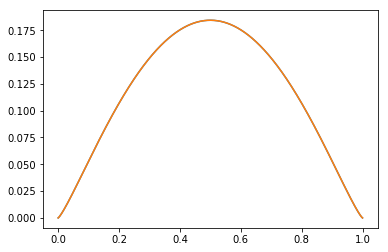

In [215]:
x = np.linspace(0,1,1000)
plt.plot(x, x**1.22*(1-x)**1.22)
plt.show()

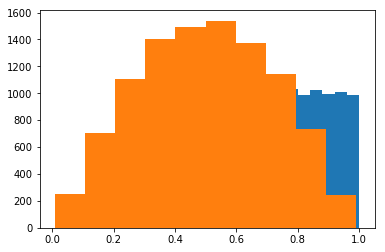

In [222]:
# Equations p1B10,b11

def get_RcRvir_eta(size=100):
    x,y = np.random.uniform(0,1,[2,size*10])
    y *= 0.2
    x = x[y<x**1.22*(1-x)**1.22]
    eta = x[:size].copy()
    RcRvir = np.random.uniform(0.6,1,size)
    return RcRvir, eta

RcRvir, eta = get_RcRvir_eta(10000)
plt.hist(RcRvir)
plt.hist(eta)
plt.show()

# TODO: Concentration scatter!

# Subhalo radial bias

Does not depend on the size of the host halo. 

\S 3.3 of Paper III

In [223]:
def p3e5(x, eta=4.0, nu=2.0):
    return 2**nu * x**eta / (1.0+x)**nu

# Radial bias vs 

From paper III:

We also assume that the radial bias function
is independent of the mass of the subhaloes. This is a valid
assumption, since van den Bosch et al. (2016) have shown
that there is little to no radial segregation of subhaloes by
present-day mass.


# SHMF